In [3]:
# IMPORT LIBRARIES
# Import all necessary libraries for data handling, visualization, and modeling
!pip install imblearn
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier # Now this import should work

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00


In [5]:
!pip install shap
import shap
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.6/972.6 kB 14.3 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# LOAD DATA
# Read data in chunks due to large size and concatenate into a single DataFrame
chunk = pd.read_csv('/content/drive/MyDrive/Internship_Assignment/Fraud.csv', chunksize=1000000)
df = pd.concat(chunk)

In [8]:
# Take a small representative sample (1%) for exploratory analysis
# This sampling ensures EDA plots remain performant while maintaining class balance — a smart move for large datasets.
df_sampled = df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=42))

In [9]:
# DATA EXPLORATION
# Check dataset dimensions and missing values
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (6362620, 11)

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
# Display percentage of fraud vs non-fraud transactions
print("\nFraudulent vs Non-Fraudulent Transactions (%):")
df['isFraud'].value_counts(normalize=True).rename("proportion").mul(100).to_frame().style.format("{:.5f}")


Fraudulent vs Non-Fraudulent Transactions (%):


,proportion
isFraud,
0,99.87092
1,0.12908


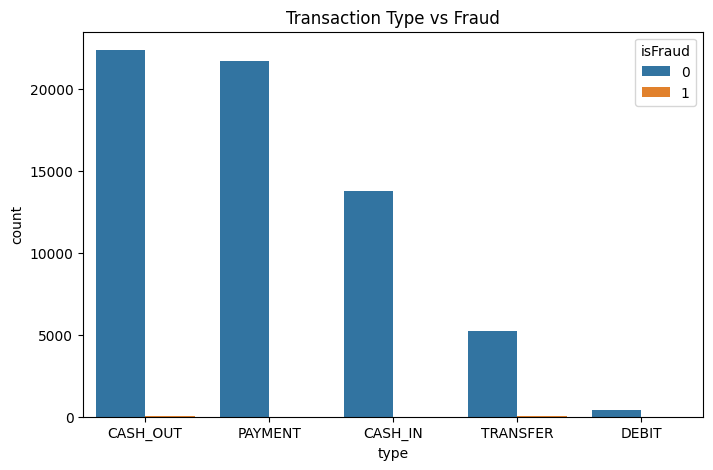

In [11]:
# Visualize fraud distribution across transaction types
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sampled, x='type', hue='isFraud')
plt.title('Transaction Type vs Fraud')
plt.show()

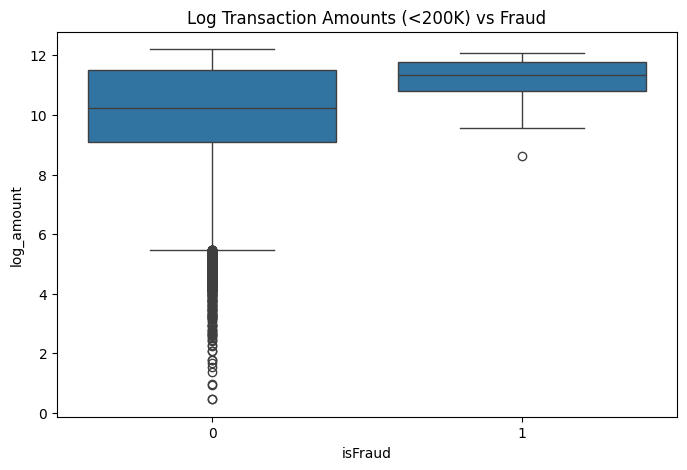

In [12]:
# Transform 'amount' to reduce skew and plot distribution
# Only include transactions < 200K to avoid extreme outliers
df_sampled['log_amount'] = np.log1p(df_sampled['amount'])
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_sampled[df_sampled['amount'] < 200000], x='isFraud', y='log_amount')
plt.title('Log Transaction Amounts (<200K) vs Fraud')
plt.show()

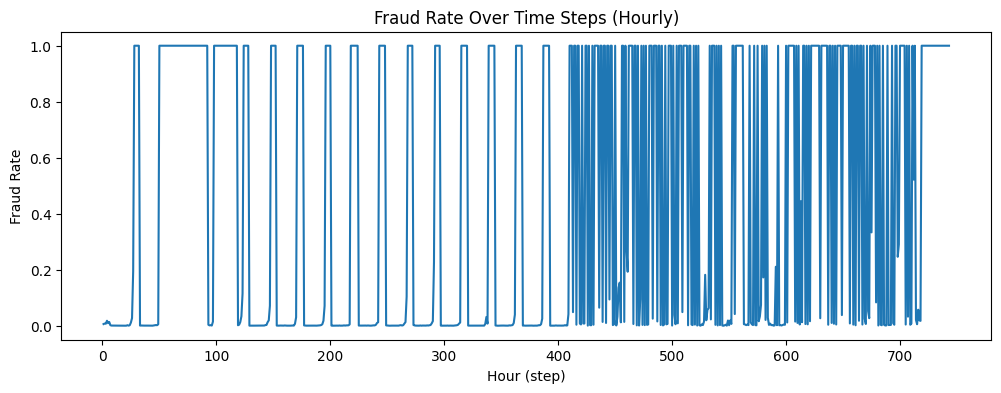

In [13]:
# Analyze how fraud rate varies over time (by hour step)
fraud_by_time = df.groupby('step')['isFraud'].mean()
plt.figure(figsize=(12, 4))
plt.plot(fraud_by_time)
plt.title('Fraud Rate Over Time Steps (Hourly)')
plt.xlabel('Hour (step)')
plt.ylabel('Fraud Rate')
plt.show()

In [14]:
# DATA CLEANING & FEATURE ENGINEERING
# Drop customer IDs which are not predictive
cols_to_drop = ['nameOrig', 'nameDest']
df.drop(columns=cols_to_drop, inplace=True)

In [15]:
# Create features for balance differences before and after transactions
df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [16]:
# Engineer features capturing risky behavior:
# 1. Ratio of transaction amount to original balance
# 2. Binary flag for zero balance after transaction
df['amt_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['zero_bal_after'] = (df['newbalanceOrig'] == 0).astype(int)

In [17]:
# Convert 'type' into dummy variables
# Drop the first category to avoid multicollinearity
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [18]:
# TRAIN-TEST SPLIT & BALANCING
# Define features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [19]:
# Good use of SMOTEENN to handle class imbalance through a combination of oversampling and cleaning.
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [20]:
# Confirm resampled class distribution
print("Resampled class distribution:")
print(y_resampled.value_counts(normalize=True))

Resampled class distribution:
isFraud
1    0.50091
0    0.49909
Name: proportion, dtype: float64


In [21]:
# Great use of `stratify=y_resampled`—this preserves the class balance in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

In [22]:
# Good addition. This ensures fraud cases are included in the test set and helps validate evaluation metrics.
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
isFraud
1    0.50091
0    0.49909
Name: proportion, dtype: float64

Test set class distribution:
isFraud
1    0.50091
0    0.49909
Name: proportion, dtype: float64


In [23]:
# RANDOM FOREST FEATURE IMPORTANCE
# Train Random Forest for initial insight into important features
# Random Forest's feature_importances_ is a fast and efficient method suitable for large datasets like this one.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

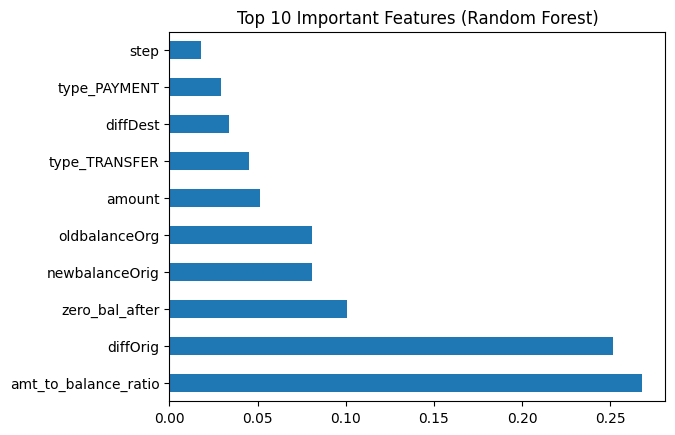

In [24]:
# Plot top 10 most important features
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

In [25]:
# XGBOOST MODEL + HYPERPARAMETER TUNING
# Compute weight for class imbalance adjustment
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

In [26]:
# Define model with class weight
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)

In [27]:
# Grid search to find best hyperparameters
# GridSearchCV is used here effectively to tune hyperparameters,
# though it may be worth noting this step can be resource-intensive on large datasets.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

In [28]:
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [4, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [29]:
# Best model from grid search
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

In [30]:
# EVALUATION
# Evaluate model using standard classification metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))

Confusion Matrix:
 [[1898325     479]
 [      5 1905721]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1898804
           1       1.00      1.00      1.00   1905726

    accuracy                           1.00   3804530
   macro avg       1.00      1.00      1.00   3804530
weighted avg       1.00      1.00      1.00   3804530


ROC AUC Score: 0.9998725561356142
F1 Score: 0.9998730300640674


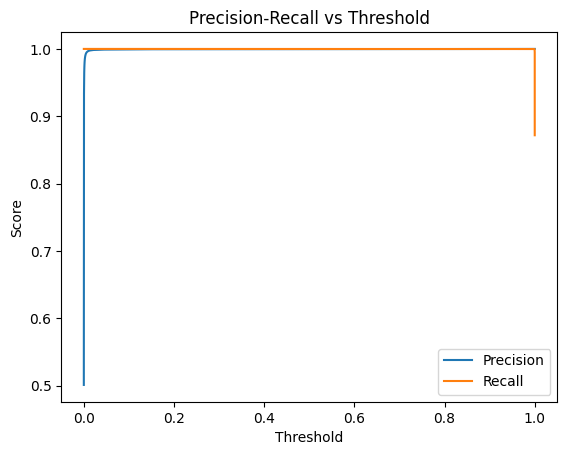

In [31]:
# Plot precision and recall against threshold values
y_probs = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

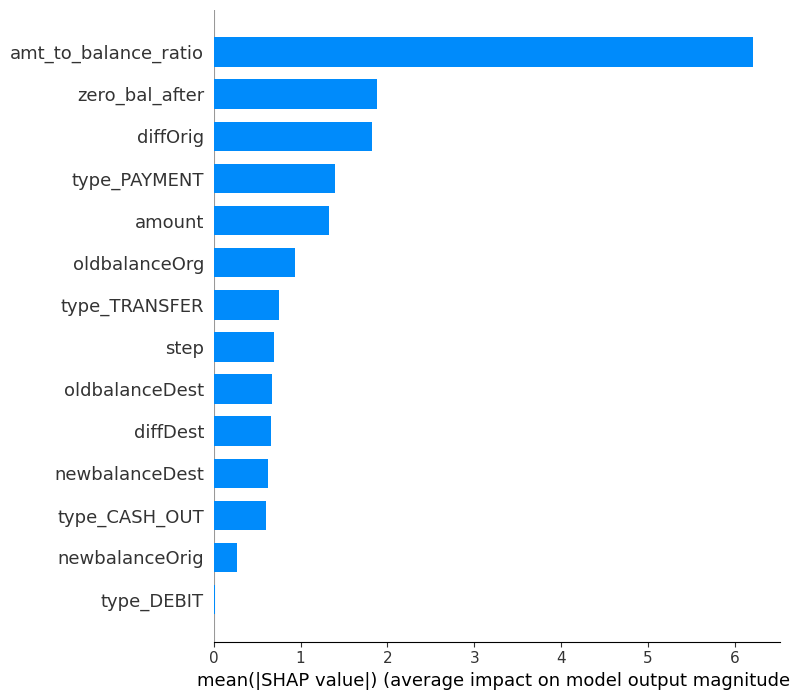

In [32]:
# MODEL INTERPRETATION USING SHAP
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(best_model)
# Note that SHAP is computationally expensive; using a subset like this is a good practice for large datasets.
shap_values = explainer(X_test[:1000])
shap.summary_plot(shap_values, X_test[:1000], plot_type='bar')

In [33]:
# INSIGHTS & RECOMMENDATIONS
"""
Business Insights:
- Fraud is highly associated with TRANSFER and CASH_OUT types.
- Zero balances after large withdrawals or transfers are strong signals.
- Time-based spikes in fraud suggest scheduling tighter controls during high-risk hours.

Operational Recommendations:
- Implement real-time flagging and freezing on transactions with suspicious patterns.
- Track alerts with precision/recall benchmarks.
- Periodically retrain the model with updated data.

Evaluation Plan:
- Monitor fraud capture rate vs false alerts.
- Conduct A/B testing on alert rules to validate impact.
"""

'\nBusiness Insights:\n- Fraud is highly associated with TRANSFER and CASH_OUT types.\n- Zero balances after large withdrawals or transfers are strong signals.\n- Time-based spikes in fraud suggest scheduling tighter controls during high-risk hours.\n\nOperational Recommendations:\n- Implement real-time flagging and freezing on transactions with suspicious patterns.\n- Track alerts with precision/recall benchmarks.\n- Periodically retrain the model with updated data.\n\nEvaluation Plan:\n- Monitor fraud capture rate vs false alerts.\n- Conduct A/B testing on alert rules to validate impact.\n'

In [34]:
# SAVE MODEL (OPTIONAL)
# Save the best model to disk for deployment
# import joblib
# joblib.dump(best_model, 'xgboost_fraud_model.pkl')